# Imports

In [3]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Basic imports
import pandas as pd
from tqdm import tqdm
import numpy as np
from scipy.stats import randint, uniform

# Visualization imports
from ydata_profiling import ProfileReport
import shap
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# GPU
import cupy as cp
import cudf
from cuml.metrics import  accuracy_score, roc_auc_score
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

# EDA

In [4]:
df = pd.read_csv('Data/bank-full.csv', sep=';')

### **Bank Client Data**

The dataset contains information about bank clients. Here is the information organized in a table format:

#### **Client Information**
| Attribute | Description                   | Type        | Possible Values                                                                 |
|-----------|-------------------------------|-------------|---------------------------------------------------------------------------------|
| **Age**       | Client age                    | Numeric     |                                                                                 |
| **Job**       | Type of job                   | Categorical | *admin.*, *unknown*, *unemployed*, *management*, *housemaid*, *entrepreneur*, *student*, *blue-collar*, *self-employed*, *retired*, *technician*, *services* |
| **Marital**   | Marital status                | Categorical | *married*, *divorced (means divorced or widowed)*, *single*                                                |
| **Education** | Education level               | Categorical | *unknown*, *secondary*, *primary*, *tertiary*                                   |
| **Default**   | Has credit in default?        | Binary      | *yes*, *no*                                                                     |
| **Balance**   | Average yearly balance, euros | Numeric     |                                                                                 |
| **Housing**   | Has housing loan?             | Binary      | *yes*, *no*                                                                     |
| **Loan**      | Has personal loan?            | Binary      | *yes*, *no*                                                                     |

#### **Related with the last contact of the current campaign**
| Attribute | Description                   | Type        | Possible Values                                                                 |
|-----------|-------------------------------|-------------|---------------------------------------------------------------------------------|
| **Contact**   | Contact communication type    | Categorical | *unknown*, *telephone*, *cellular*                                             |
| **Day**       | Last contact day of the month | Numeric     |                                                                                 |
| **Month**     | Last contact month of year    | Categorical | *jan*, *feb*, *mar*, *apr*, *may*, *jun*, *jul*, *aug*, *sep*, *oct*, *nov* *dec*                                                |
| **Duration**  | Last contact duration, seconds| Numeric     |                                                                                 |

#### **Other attributes**
| Attribute | Description                   | Type        | Possible Values                                                                 |
|-----------|-------------------------------|-------------|---------------------------------------------------------------------------------|
| **Campaign**  | Number of contacts in campaign| Numeric     |                                                                                 |
| **Pdays**     | Days since last contact       | Numeric     | -1 means not previously contacted                                             |
| **Previous**  | Number of contacts prior to this campaign | Numeric |                                                                         |
| **Poutcome**  | Outcome of previous marketing campaign  | Categorical | *unknown*, *other*, *failure*, *success*                                       |

#### **Output variable (desired target)**
| Attribute | Description                   | Type        | Possible Values                                                                 |
|-----------|-------------------------------|-------------|---------------------------------------------------------------------------------|
| **Y**  | has the client subscribed a term deposit?| binary     |  *yes*, *no*  |


In [5]:
# create report
profile = ProfileReport(
    df,
    title='Bank Marketing Profiling Report',
    interactions=None,
    duplicates=None
)

# profile.to_notebook_iframe()
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

In [5]:
# Define columns
ordinal_feature = ['pdays']
nominal_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'previous']
target = 'y'


# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[np.sort(df.pdays.unique())]), ordinal_feature),
        ('nominal', OneHotEncoder(drop='first'), nominal_features),
        ('numeric', StandardScaler(), numeric_features),
    ],
    remainder='passthrough'
)

# Encode the target column
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target].values)

# Split data into Train-Validation-Test sets
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.y.to_numpy())

In [6]:
# Preprocess train data using the preprocessor
train_preprocessed = preprocessor.fit_transform(train)
X_train = train_preprocessed[:, :-1]
y_train = train_preprocessed[:, -1]

# Preprocess test data using the preprocessor
test_preprocessed = preprocessor.transform(test)
X_test = test_preprocessed[:, :-1]
y_test = test_preprocessed[:, -1]

# Cross Validation

In [4]:
# Create a list of model objects
models = [
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier(tree_method='gpu_hist')),
    ('Logistic Regression', LogisticRegression()),
    ('K Neighbors', KNeighborsClassifier())
]

In [ ]:
# Define the KFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}  # Dictionary to store model performance

for name, model in models:
    accuracy_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_idx, val_idx in tqdm(skf.split(X_train, y_train), desc="Cross-Validation"):
        # Train the model on the train subset
        model.fit(X_train[train_idx], y_train[train_idx])

        # Predict probabilities for the positive class
        y_pred_prob = model.predict_proba(X_train[val_idx])[:, 1]

        # Predict classes
        y_pred = model.predict(X_train[val_idx])

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_train[val_idx], y_pred)
        f1score = f1_score(y_train[val_idx], y_pred)
        roc_auc = roc_auc_score(y_train[val_idx], y_pred_prob)

        # Append scores to lists
        accuracy_scores.append(accuracy)
        f1_scores.append(f1score)
        roc_auc_scores.append(roc_auc)


    mean_accuracy = np.mean(accuracy_scores)
    mean_f1_score = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)

    results[name] = {
        'Accuracy': mean_accuracy,
        'F1-Score': mean_f1_score,
        'ROC-AUC': mean_roc_auc
    }

Cross-Validation: 5it [00:08,  1.70s/it]
Cross-Validation: 5it [00:01,  3.02it/s]
Cross-Validation: 5it [00:02,  2.31it/s]
Cross-Validation: 5it [00:00, 12.61it/s]


In [ ]:
# Print results
for model_name, scores in results.items():
    print(f"Model: {model_name}")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")
    print()

Model: Random Forest
Accuracy: 0.9004
F1-Score: 0.3633
ROC-AUC: 0.9246

Model: XGBoost
Accuracy: 0.9064
F1-Score: 0.5475
ROC-AUC: 0.9313

Model: Logistic Regression
Accuracy: 0.9016
F1-Score: 0.4498
ROC-AUC: 0.9067

Model: K Neighbors
Accuracy: 0.8923
F1-Score: 0.4205
ROC-AUC: 0.8294



XGBoost performs best among all these algorithms.

# Fine-Tuning XGBoost

In [18]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),  # Extended the range for max_depth
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),  # Adjusted the range for subsample
    'colsample_bytree': uniform(0.6, 0.4),  # Adjusted the range for colsample_bytree
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 20),  # Extended the range for min_child_weight
}

In [20]:
# Create a randomized search object inside the pipeline
random_search = RandomizedSearchCV(
    XGBClassifier(tree_method='gpu_hist'),
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [21]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79cc60b466e0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79cc60b44e80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79cc616de0e0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79cc60b464a0>},
                   scoring='accuracy', verbose=1)

In [22]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print(best_params)
best_estimator

{'colsample_bytree': 0.9734163451420466, 'gamma': 1.8267794233140306, 'learning_rate': 0.12576421180837344, 'max_depth': 7, 'min_child_weight': 16, 'n_estimators': 407, 'subsample': 0.942678781840611}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9734163451420466, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.8267794233140306, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12576421180837344, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=16, missing=nan, monotone_constraints=None,
              n_estimators=407, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Prediction and Results Interpretation

In [24]:
test_accuracy = best_estimator.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9074422205020458


In [25]:
# Generate and print the classification report
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7985
         1.0       0.65      0.46      0.54      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.72      0.74      9043
weighted avg       0.90      0.91      0.90      9043



In [66]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['No', 'Yes']

# Create an interactive heatmap using Plotly
fig = px.imshow(cm, x=class_labels, y=class_labels,
                labels=dict(x="Predicted Labels", y="True Labels", color="Count"),
                title="Confusion Matrix",
                color_continuous_scale="Blues")
fig.update_layout(width=700, height=500)

# Set count values on tiles
fig.update_traces(texttemplate='%{text}', text=cm.tolist())

# Display the interactive plot
fig.show()

In [49]:
# Get feature importances
importances = best_estimator.feature_importances_

# Get feature names
feature_names = list(ordinal_feature+preprocessor.transformers_[1][1].get_feature_names_out().tolist()+numeric_features)  # Replace with your actual feature names

# Create a DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create an interactive bar plot using Plotly
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importances from XGBoost Model')

# Display the interactive plot
fig.show()

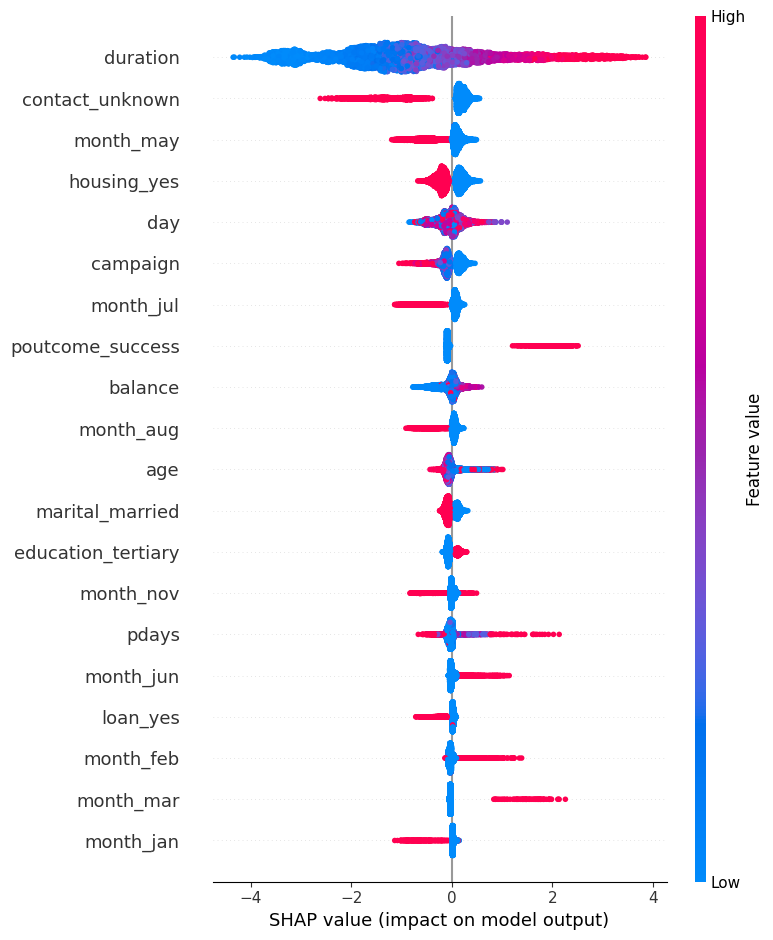

In [70]:
# Create an explainer using SHAP
explainer = shap.Explainer(best_estimator)

# Calculate SHAP values for the testing data
shap_values = explainer.shap_values(X_test)

# Visualize feature importances using a summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)